# **Stock Price Prediction - Simple Regression Model**
COSC 325 Course Project  
Fall 2024
## Members:
  * John Paul Saia  
  * Riley Taylor  
  * Shanna Wallace  

## Objective: 
Create a machine learning model to predict the stock's closing price in 7 days

## The Data
**Data set:** Berkshire Hathaway daily stock price and volume traded from 2015-01-02 to 2024-07-29  
**Format:** .csv file  

#### Target and features:

| Target | Description |
| :- | :- | 
| Close 7 Days | Closing price 7 days from the trading day |

<br>

  | Features | Description |
  | :- | :- | 
  | Date | The day the price data is from (yyyy-mm-dd) |
  | Open | Opening price | 
  | High | Highest price |
  | Low | Lowest price |
  | Close | Closing price |
  | Adj Close | Closing price after adjustments for applicable splits and dividend distributions |
  | Volume | Total number of shares traded that day |

## The Baseline Model
* Create and compare 3 regression models using 1 feature:
  * Linear Regression with SKLearn's default class
  * Complex regression model with polynomial expansion.  
  * Linear Regression with gradient descent.  
* Optimize linear model performance. 
<br>

---  


# Create Linear Regression Model:

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

## Load and Prepare Data:
* Load csv file contents to a DataFrame
* Add column for the target, Close 7 Days, by shifting Close by 7 days
* Add the additional features
* Clean the data by removing rows with missing values  

#### Additional Features:
| Features | Description |
| :- | :- | 
| High - Low | Difference between highest and lowest price |
| Open - Close | Amount price changed from open to close |
| 7 Day STD DEV | Standard deviation of closing price over previous 7 days |
| 7 Day MA | Moving averages of closing price over previous 7 days |
| 14 Day MA | Moving averages of closing price over previous 14 days |
| 21 Day MA | Moving averages of closing price over previous 21 days |  

In [3]:
RANDOM_STATE = 42
file = "./berkshire_hathaway_data.csv"
stock_data = pd.read_csv(file)

# Ensure the Date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
# Convert 'Date' to epoch time
stock_data['Epoch Time'] = stock_data['Date'].apply(lambda x: int(x.timestamp()))
# Add target: Closing price 7 days later
stock_data['Close 7 Days'] = stock_data['Close'].shift(-7)
# Keep only the necessary columns
stock_data = stock_data[['Epoch Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close 7 Days']]
# Drop rows with missing data
stock_data = stock_data.dropna().reset_index(drop=True)
stock_data.head()

,Epoch Time,Open,High,Low,Close,Volume,Close 7 Days
0,1420156800,151.500000,151.600006,148.500000,149.169998,3436400,148.630005
1,1420416000,148.809998,149.000000,146.779999,147.000000,4168800,147.820007
2,1420502400,147.639999,148.529999,146.110001,146.839996,4116100,147.580002
3,1420588800,147.940002,149.139999,147.649994,148.880005,4159100,149.210007
4,1420675200,150.600006,151.369995,150.509995,151.369995,4282100,148.630005


## Change in Stock Prices Over Time

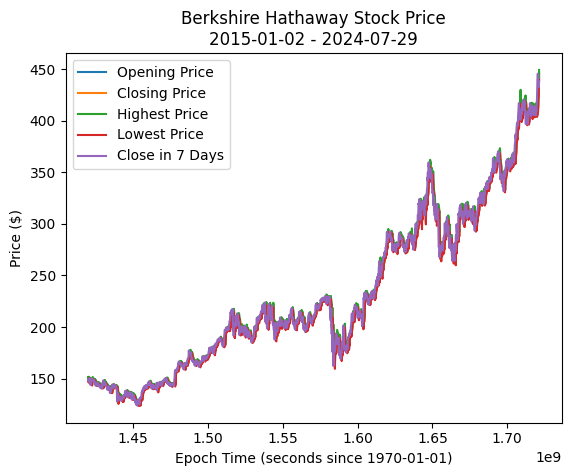

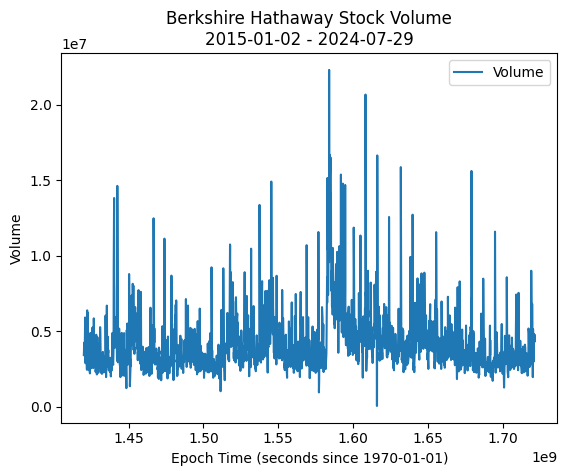

In [4]:
import matplotlib.pyplot as plt

# Plot stock prices with Epoch Time as the x-axis
plt.plot(stock_data['Epoch Time'], stock_data['Open'], label="Opening Price")
plt.plot(stock_data['Epoch Time'], stock_data['Close'], label="Closing Price")
plt.plot(stock_data['Epoch Time'], stock_data['High'], label="Highest Price")
plt.plot(stock_data['Epoch Time'], stock_data['Low'], label="Lowest Price")
plt.plot(stock_data['Epoch Time'], stock_data['Close 7 Days'], label="Close in 7 Days")
plt.title("Berkshire Hathaway Stock Price\n2015-01-02 - 2024-07-29")
plt.xlabel("Epoch Time (seconds since 1970-01-01)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# Plot stock volume with Epoch Time as the x-axis
plt.plot(stock_data['Epoch Time'], stock_data['Volume'], label="Volume")
plt.title("Berkshire Hathaway Stock Volume\n2015-01-02 - 2024-07-29")
plt.xlabel("Epoch Time (seconds since 1970-01-01)")
plt.ylabel("Volume")
plt.legend()
plt.show()


## Feature Selection:
* Generate scatter plot to visualize relationships between variables
* Calculate correlation coefficient of each feature with the target and drop features with correlation value less than 0.5
* Look at the correlation coefficient of the features with the other features and drop ones that are highly correlated with each other


Text(0.5, 1.08, 'Given features')

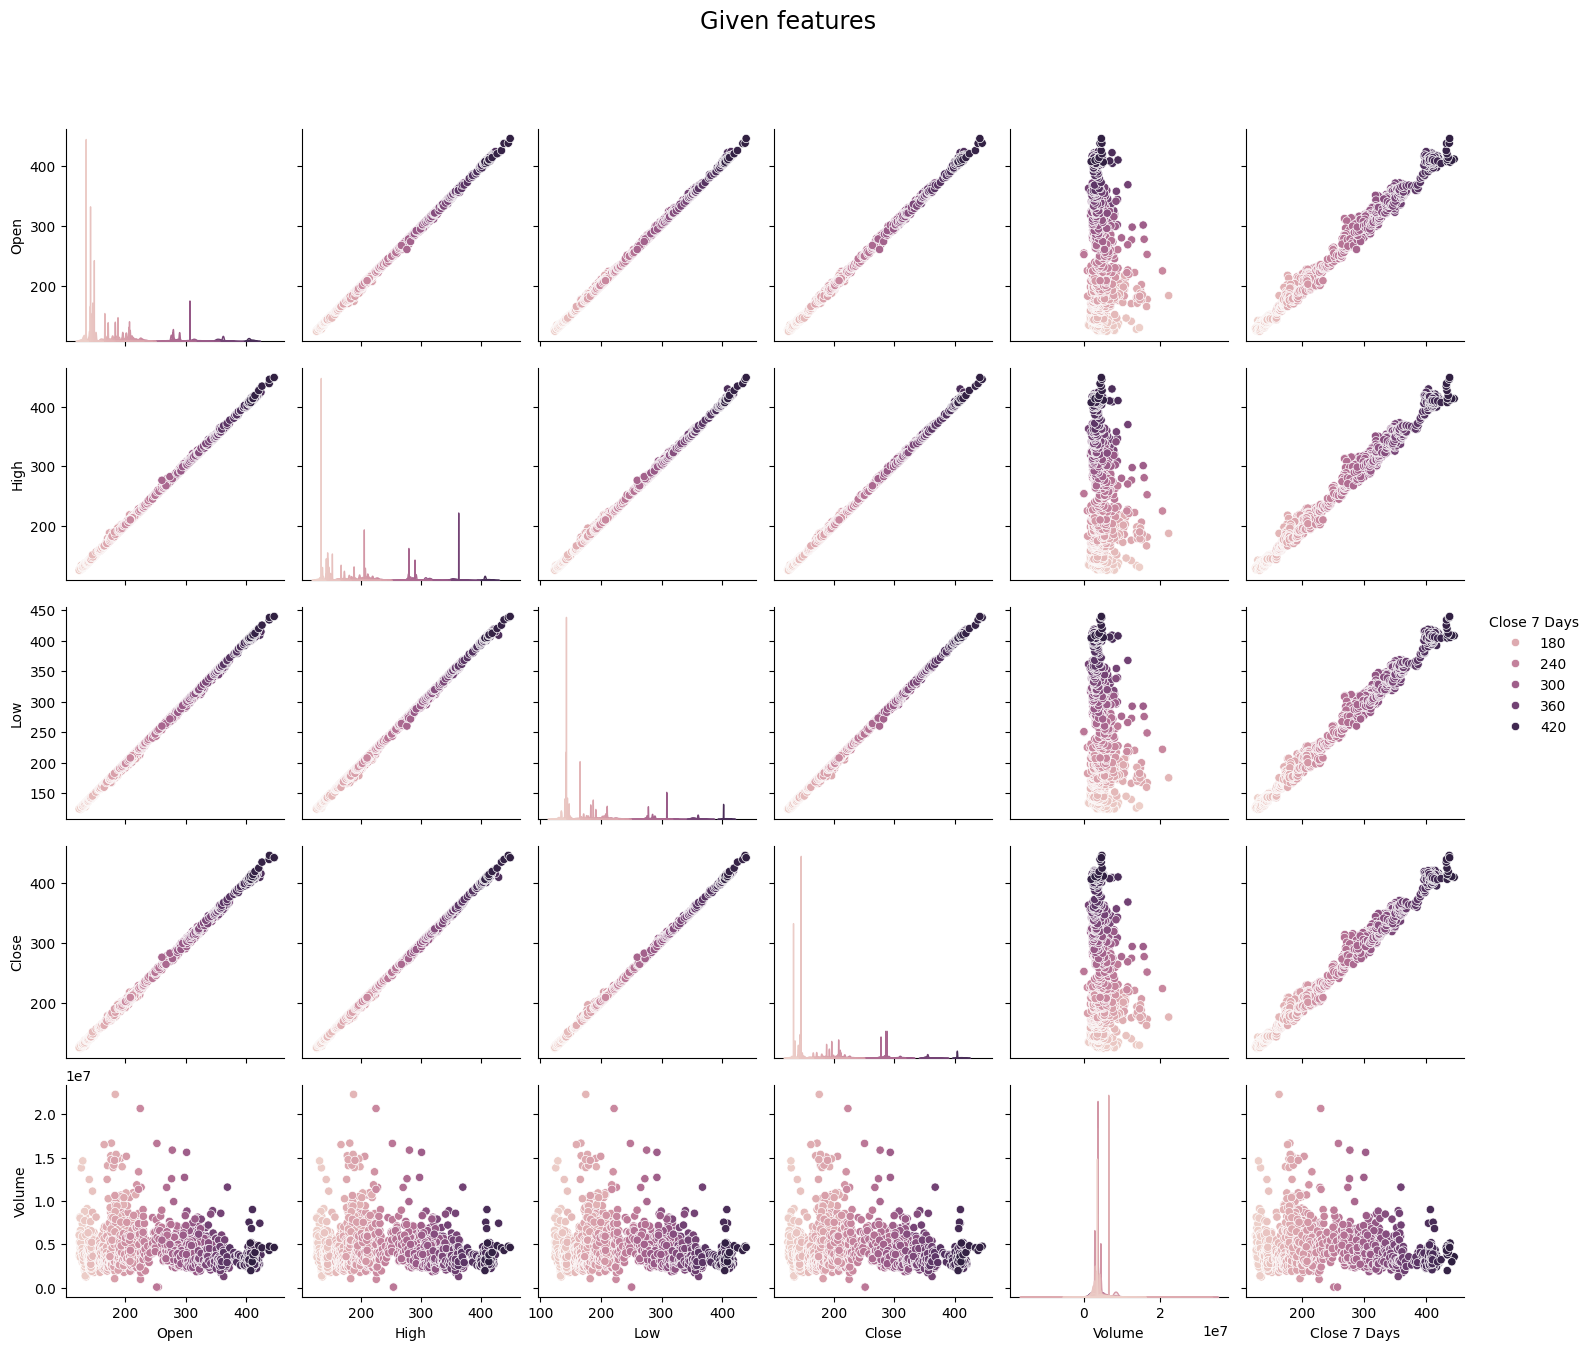

In [5]:
# Display features data trends for the given features with Seaborn pairplot.
given_features = sns.pairplot(stock_data, x_vars=['Open', 'High', 'Low', 'Close', 'Volume', 'Close 7 Days'], 
              y_vars=['Open', 'High', 'Low', 'Close', 'Volume'], hue='Close 7 Days')
given_features.figure.suptitle("Given features", y=1.08, fontsize='xx-large')

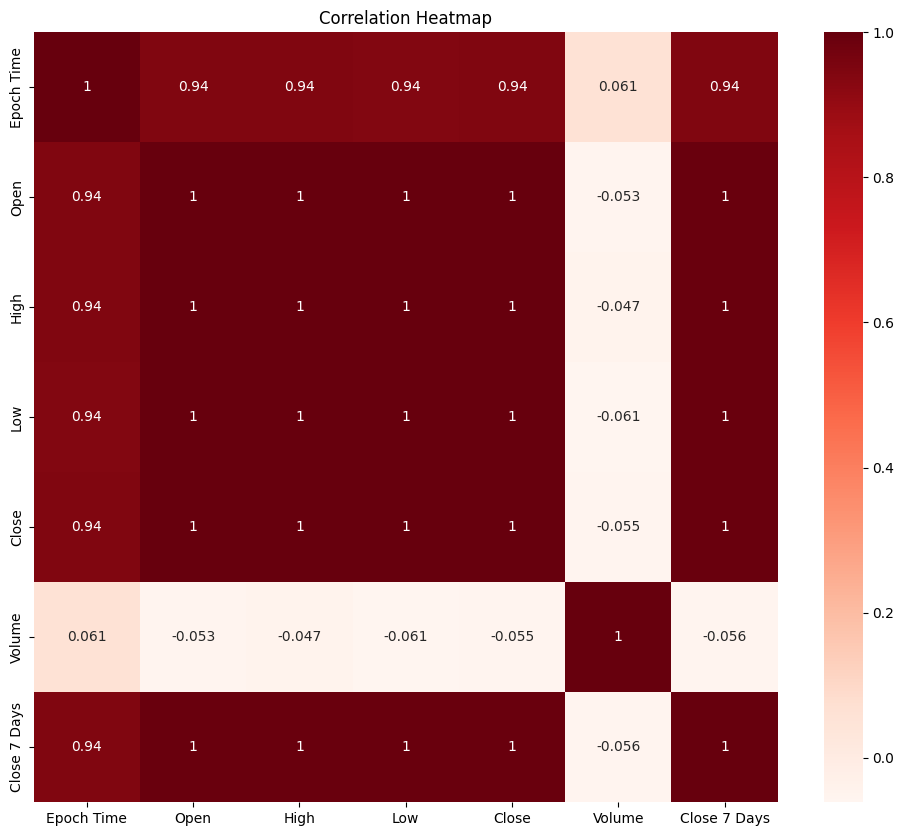

              Epoch Time      Open      High       Low     Close    Volume  \
Epoch Time      1.000000  0.942105  0.943157  0.941361  0.942223  0.060807   
Open            0.942105  1.000000  0.999815  0.999776  0.999570 -0.053169   
High            0.943157  0.999815  1.000000  0.999725  0.999792 -0.047492   
Low             0.941361  0.999776  0.999725  1.000000  0.999799 -0.061293   
Close           0.942223  0.999570  0.999792  0.999799  1.000000 -0.055106   
Volume          0.060807 -0.053169 -0.047492 -0.061293 -0.055106  1.000000   
Close 7 Days    0.942199  0.995257  0.995485  0.995595  0.995708 -0.056169   

              Close 7 Days  
Epoch Time        0.942199  
Open              0.995257  
High              0.995485  
Low               0.995595  
Close             0.995708  
Volume           -0.056169  
Close 7 Days      1.000000  
Highly correlated features with 'Close 7 Days':
Epoch Time      0.942199
Open            0.995257
High            0.995485
Low             0.99

In [6]:
# Using Pearson Correlation
plt.figure(figsize=(12, 10))
cor = stock_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation Heatmap")
plt.show()

# Display correlation matrix
print(cor)

# Correlation with the target variable
cor_target = abs(cor["Close 7 Days"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.75]
print("Highly correlated features with 'Close 7 Days':")
print(relevant_features)


### Create Training and Test Sets
* Extract target and selected features
* Split data in to training and testing sets
    * Training 80% / Testing 20%

In [7]:
# Drop relevant features that are highly correlated with each other
relevant_feature_list = ["Close"]

X_relevant = stock_data[relevant_feature_list]
y = stock_data['Close 7 Days']

# Define the proportion of data for training
train_ratio = 0.8  # Use 80% for training, 20% for testing

# Sort data by time to ensure chronological order
stock_data = stock_data.sort_values(by='Epoch Time').reset_index(drop=True)

# Split data into training and testing sets
train_size = int(len(stock_data) * train_ratio)

X_train = stock_data[relevant_feature_list].iloc[:train_size]
X_test = stock_data[relevant_feature_list].iloc[train_size:]
y_train = stock_data['Close 7 Days'].iloc[:train_size]
y_test = stock_data['Close 7 Days'].iloc[train_size:]

# Print selected features and set sizes
print(f"Training set size: {X_train.shape[0]}\nTesting set size: {X_test.shape[0]}")


Training set size: 1920
Testing set size: 481


## Simple Linear Regression Model with OLS
### Create and Fit Linear Model using sklearn's default, Ordinary Least Squares

In [8]:
# Create the simple Model
ols_model = LinearRegression()

# Create training sets and train the model
ols_X_train = X_train
ols_X_test = X_test

ols_model.fit(ols_X_train, y_train)


LinearRegression()

### Get Predictions and Analyze Performance
* Plot the model
* Calculate performance metrics:
    * Bias
    * Variance
    * RMSE (Root Mean Squared Error)
    * MAE (Mean Absolue Error)

Simple Model:
  Bias: 1982.8609019077014
  Variance: 1889.004826501156
  RMSE: $9.115334095652814
  MAE: $7.314436958452803


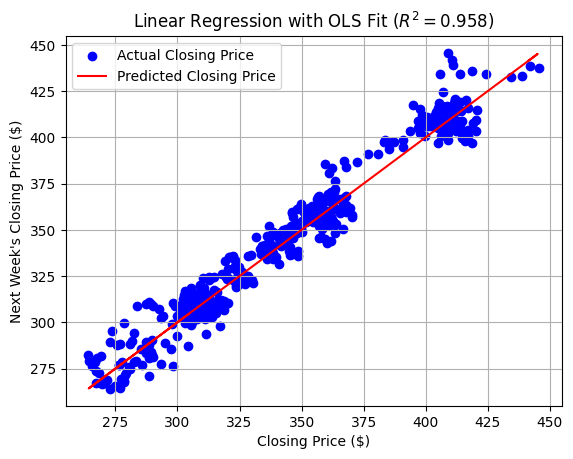

In [9]:
# simple_pred = simple_model.predict(simple_X_test)
ols_pred = pd.Series(ols_model.predict(X_test), index=X_test.index)

# Calculate the mean of the predictions (expected prediction)
ols_mean_pred = np.mean(ols_pred)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
ols_bias = np.mean((y_test - ols_mean_pred) ** 2)
ols_variance = np.mean((ols_pred - ols_mean_pred) ** 2)
ols_rmse = root_mean_squared_error(y_test, ols_pred)
ols_r2 = r2_score(y_test, ols_pred)
ols_mae = mean_absolute_error(y_test, ols_pred)

print(f"Simple Model:\n  Bias: {ols_bias}\n  Variance: {ols_variance}\n  RMSE: ${ols_rmse}\n  MAE: ${ols_mae}")

plt.scatter(ols_X_test, y_test, label='Actual Closing Price', color='blue')
plt.plot(ols_pred, ols_pred, label='Predicted Closing Price', color='red')
plt.title(f"Closing Price vs. Next Week's Closing Price (Simple Linear Model)")
plt.title(f"Linear Regression with OLS Fit ($R^2=${ols_r2:.3f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.grid(True)


## Simple Linear Model with Polynomial Expansion
#### Determine optimal number of degrees to use:
* Test degree values 1 through 10 
* Compare R2 and RMSE for each
* Choose degree number that gives highest R2 and lowest RMSE


Degree with maximum R2: 1 with 0.9579992828922019
Degree with minimum RMSE: 1 with $9.11533409565285


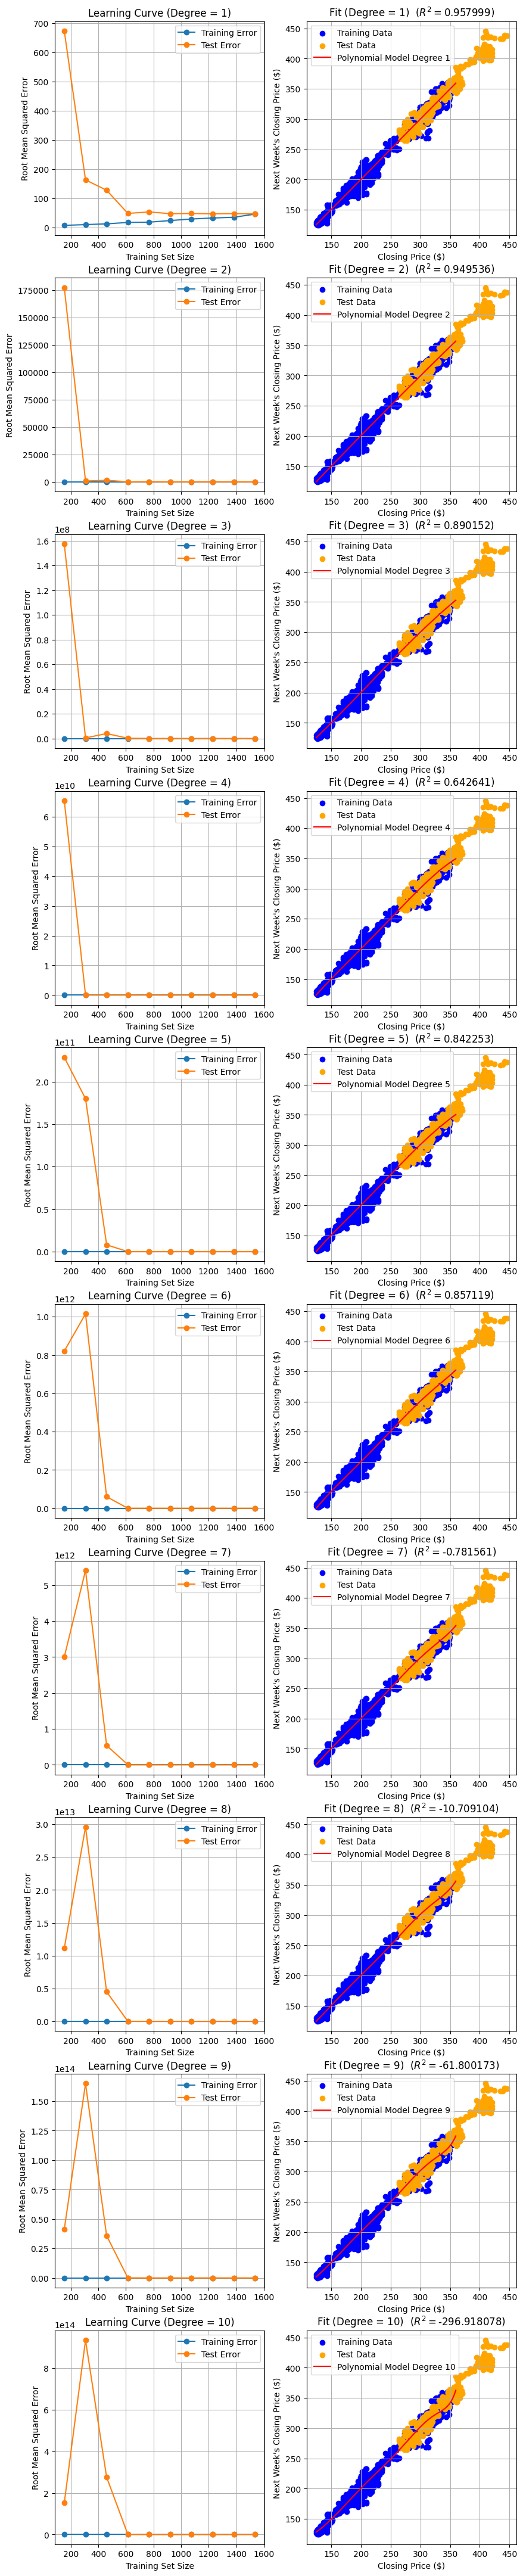

In [10]:
rmse_results = [0] * 10
r2_results = [0] * 10

fig, axes = plt.subplots(10, 2, figsize=(10,55))
# row for the subplot
r = 0

# Define a function for plotting the learning curve
for degree in range(1, 11):
    # Complex Model: Using the features with Polynomial Expansion
    poly = PolynomialFeatures(degree=degree)

    # Transform the training and test data
    X_train_poly = poly.fit_transform(X_train.values)
    X_test_poly = poly.transform(X_test.values)

    # Initialize the linear regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    poly_test_predictions = poly_model.predict(X_test_poly)

    # Calculate the mean of the predictions (expected prediction)
    poly_mean_prediction = np.mean(poly_test_predictions)

    # Calculate learning curves for the polynomial model
    train_sizes, train_scores, test_scores = learning_curve(
        poly_model, X_train_poly, y_train, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
    )

    # Calculate mean error
    train_errors = -np.mean(train_scores, axis=1)
    test_errors = -np.mean(test_scores, axis=1)


    # set row and column for the subplot
    
    c = 0

    # Plot learning curves
    axes[r,c].plot(train_sizes, train_errors, label='Training Error', marker='o')
    axes[r,c].plot(train_sizes, test_errors, label='Test Error', marker='o')
    axes[r,c].set_title(f'Learning Curve (Degree = {degree})')
    axes[r,c].set_xlabel('Training Set Size')
    axes[r,c].set_ylabel('Root Mean Squared Error')
    axes[r,c].legend()
    axes[r,c].grid(True)

    c += 1

    # Calculate Root Mean Squared Error and R2
    rmse_results[degree - 1] = root_mean_squared_error(y_test, poly_test_predictions)
    r2_results[degree - 1] = r2_score(y_test, poly_test_predictions)

    # Visualize the learning process
    x_curve = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
    y_curve_poly = poly_model.predict(poly.transform(x_curve))


    axes[r,c].scatter(X_train, y_train, color='blue', label='Training Data')
    axes[r,c].scatter(X_test, y_test, color='orange', label='Test Data')

    axes[r,c].plot(x_curve, y_curve_poly, color='red', label=f'Polynomial Model Degree {degree}')
    axes[r,c].set_title(f'Fit (Degree = {degree})  ($R^2=${r2_results[degree - 1]:.6f})')
    axes[r,c].set_xlabel("Closing Price ($)")
    axes[r,c].set_ylabel("Next Week's Closing Price ($)")
    axes[r,c].legend()
    axes[r,c].grid(True)

    r += 1
    
# Want to minimize errors and maximize R2
max_r2 = max(r2_results)
min_rmse = min(rmse_results)
print(f"\nDegree with maximum R2: {r2_results.index(max_r2) + 1} with {max_r2}")
print(f"Degree with minimum RMSE: {rmse_results.index(min_rmse) + 1} with ${min_rmse}")

### Create Linear Model with Polynomial Expansion using Best Degree
### Get Predictions and Analyze Performance
* Plot the model
* Calculate performance metrics:
    * Bias
    * Variance
    * RMSE (Root Mean Squared Error)
    * MAE (Mean Absolue Error)

Regression Model with Polynomial Expansion:
  Bias: 1982.8609019077026
  Variance: 1889.0048265011521
  RMSE: $9.11533409565285
  MAE: $7.314436958452836


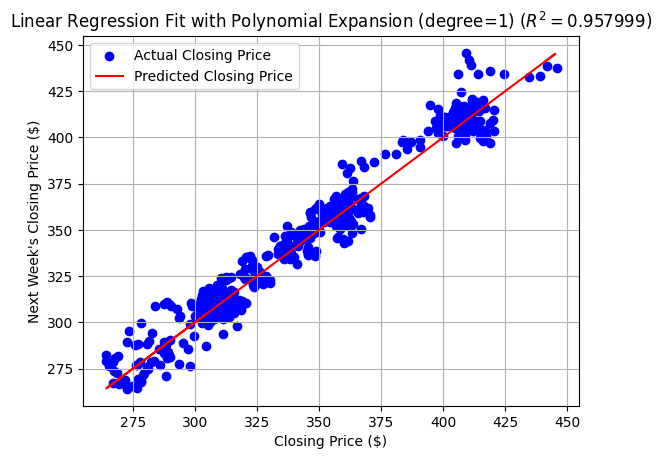

In [11]:
degree = rmse_results.index(min_rmse) + 1

# Complex Model: Using the features with Polynomial Expansion
poly = PolynomialFeatures(degree=degree)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_test_poly)

# Calculate the mean of the predictions (expected prediction)
poly_mean_pred = np.mean(poly_pred)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
poly_bias = np.mean((y_test - poly_mean_pred) ** 2)
poly_variance = np.mean((poly_pred - poly_mean_pred) ** 2)
poly_rmse = root_mean_squared_error(y_test, poly_pred)
poly_r2 = r2_score(y_test, poly_pred)
poly_mae = mean_absolute_error(y_test, poly_pred)

print(f"Regression Model with Polynomial Expansion:\n  Bias: {poly_bias}\n  Variance: {poly_variance}\n  RMSE: ${poly_rmse}\n  MAE: ${poly_mae}")

plt.scatter(X_test, y_test, label='Actual Closing Price', color='blue')
plt.plot(poly_pred, poly_pred, label='Predicted Closing Price', color='red')
plt.title(f"Linear Regression Fit with Polynomial Expansion (degree={degree}) ($R^2=${poly_r2:.6f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.grid(True)


## Simple Linear Regression Model with Gradient Descent
#### Choose best learning rate 
* Test different **learning rates** to find the **optimal learning rate** that minimizes the cost function most efficiently

In [12]:
# Define the cost function
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum(np.square(predictions - y))
    return cost

# Define the gradient descent function (with cost history tracking)
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)  # number of samples
    cost_history = np.zeros(iterations)  # To store the cost at each iteration
    
    for i in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        gradient = (1/m) * X.T.dot(errors)
        theta = theta - alpha * gradient
        cost_history[i] = compute_cost(X, y, theta)  # Save the cost at each iteration
    
    return theta, cost_history

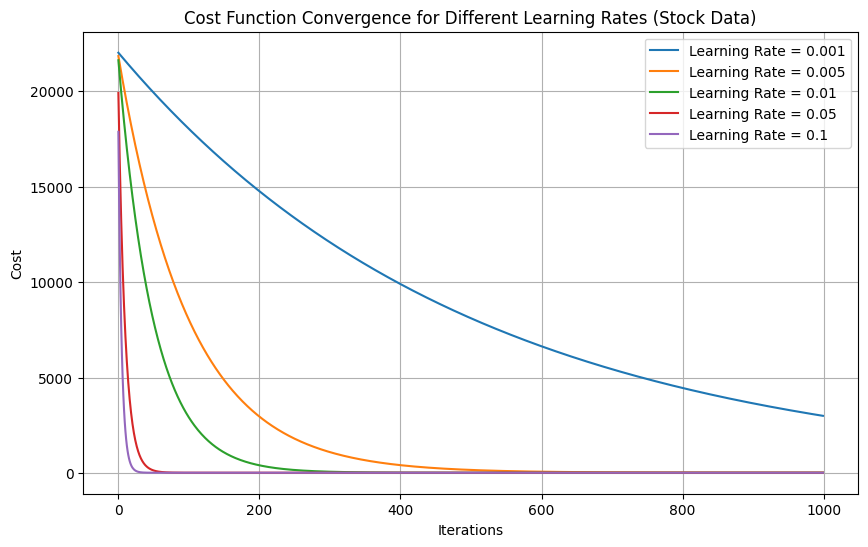

In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a column of ones to the scaled feature matrices for the intercept term
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]


# Initialize parameters for gradient descent
iterations = 1000
theta = np.zeros(X_train_scaled.shape[1])  # Initialize theta with zeros


# Test with different learning rates
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
plt.figure(figsize=(10, 6))

for alpha in learning_rates:
    theta = np.zeros(X_train_scaled.shape[1])  # Reset theta for each learning rate
    theta, cost_history = gradient_descent(X_train_scaled, y_train, theta, alpha, iterations)
    plt.plot(range(iterations), cost_history, label=f'Learning Rate = {alpha}')


# Plot the cost function convergence
plt.title('Cost Function Convergence for Different Learning Rates (Stock Data)')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

### Apply Gradient Descent
* Using the optimal learning rate (alpha) of 0.01 based on the above graph

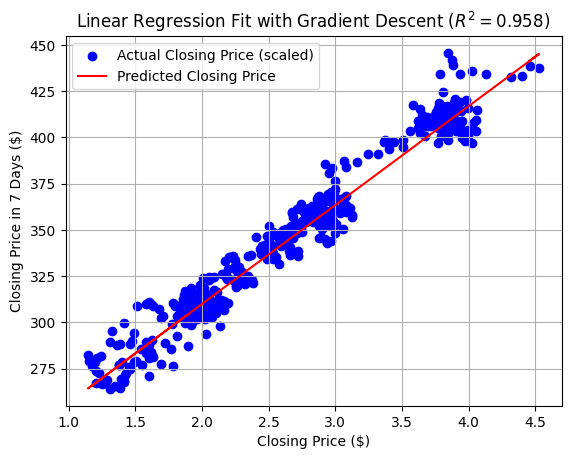

In [14]:
# Gradient Descent with optimal learning rate
alpha = 0.01
theta = np.zeros(X_train_scaled.shape[1])  
theta, cost_history = gradient_descent(X_train_scaled, y_train, theta, alpha, iterations)

# get the predictions for the final theta
gd_pred = np.dot(X_test_scaled, theta)
gd_mean_pred = np.mean(gd_pred)

# RMSE, R2, MAE, bias, and variance
gd_bias = np.mean((y_test - gd_mean_pred) ** 2)
gd_variance = np.mean((poly_pred - gd_mean_pred) ** 2)
gd_rmse = root_mean_squared_error(y_test, gd_pred)
gd_r2 = r2_score(y_test, gd_pred)
gd_mae = mean_absolute_error(y_test, gd_pred)

plt.scatter(X_test_scaled[:,1], y_test, label='Actual Closing Price (scaled)', color='blue')
plt.plot(X_test_scaled[:,1], gd_pred, label='Predicted Closing Price', color='red')
plt.title(f"Linear Regression Fit with Gradient Descent ($R^2=${gd_r2:.3f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Closing Price in 7 Days ($)")
plt.legend()
plt.grid(True)
plt.show()



### Get Confidence Intervals

OLS Confidence Interval: (np.float64(327.9426945471746), np.float64(363.8391781609265))
Polynomial Regression Confidence Interval: (np.float64(327.9426945471743), np.float64(363.83917816092645))
Gradient Descent Confidence Interval: (np.float64(327.9207873869759), np.float64(363.8312202347438))


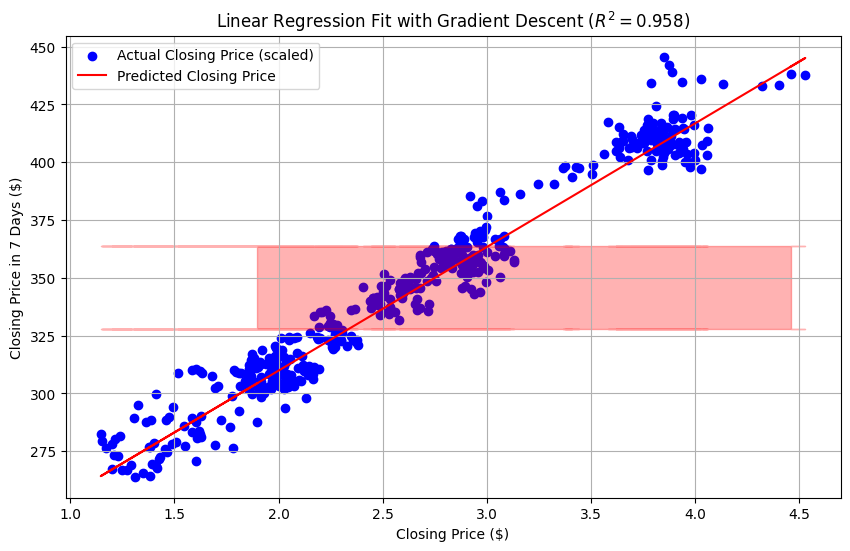

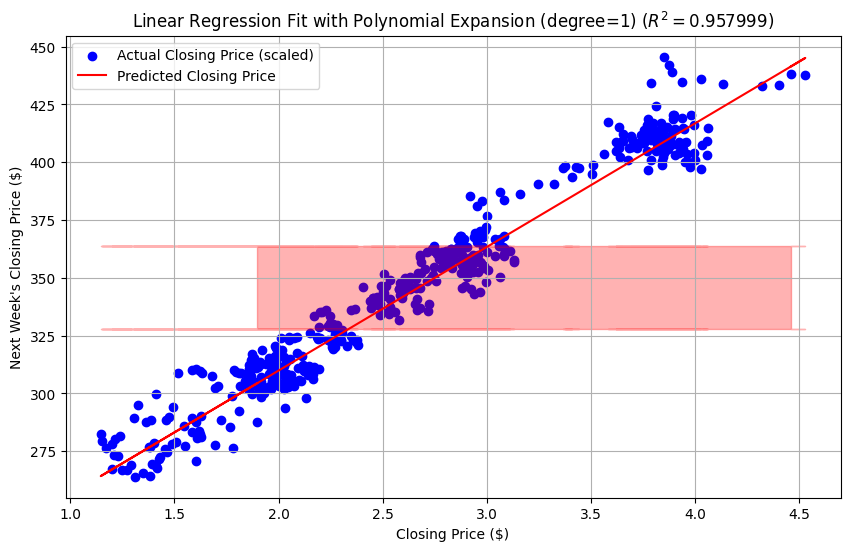

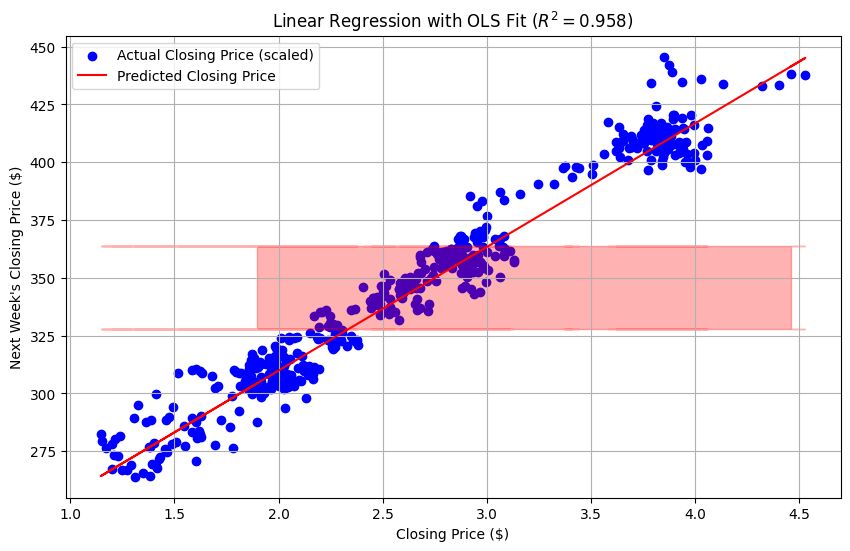

In [15]:
from scipy import stats

# Calculate Convidence Intervals

# OLS Confidence Interval
# Calculate the standard error of the predictions
ols_se = np.sqrt(np.sum((y_test - ols_pred) ** 2) / (len(y_test) - 2))

# Calculate the confidence intervals
confidence_interval_ols = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(ols_pred), scale=ols_se)
print(f"OLS Confidence Interval: {confidence_interval_ols}")

# Polynomial Regression Confidence Interval
# Calculate the standard error of the predictions
poly_se = np.sqrt(np.sum((y_test - poly_pred) ** 2) / (len(y_test) - 2))

# Calculate the confidence intervals
confidence_interval_poly = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(poly_pred), scale=poly_se)
print(f"Polynomial Regression Confidence Interval: {confidence_interval_poly}")

# Gradient Descent Confidence Interval
# Calculate the standard error of the predictions
gd_se = np.sqrt(np.sum((y_test - gd_pred) ** 2) / (len(y_test) - 2))

# Calculate the confidence intervals
confidence_interval_gd = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(gd_pred), scale=gd_se)
print(f"Gradient Descent Confidence Interval: {confidence_interval_gd}")

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:,1], y_test, label='Actual Closing Price (scaled)', color='blue')
plt.plot(X_test_scaled[:,1], gd_pred, label='Predicted Closing Price', color='red')
plt.fill_between(X_test_scaled[:,1], confidence_interval_gd[0], confidence_interval_gd[1], color='red', alpha=0.3)
plt.title(f"Linear Regression Fit with Gradient Descent ($R^2=${gd_r2:.3f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Closing Price in 7 Days ($)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:,1], y_test, label='Actual Closing Price (scaled)', color='blue')
plt.plot(X_test_scaled[:,1], poly_pred, label='Predicted Closing Price', color='red')
plt.fill_between(X_test_scaled[:,1], confidence_interval_poly[0], confidence_interval_poly[1], color='red', alpha=0.3)
plt.title(f"Linear Regression Fit with Polynomial Expansion (degree={degree}) ($R^2=${poly_r2:.6f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:,1], y_test, label='Actual Closing Price (scaled)', color='blue')
plt.plot(X_test_scaled[:,1], ols_pred, label='Predicted Closing Price', color='red')
plt.fill_between(X_test_scaled[:,1], confidence_interval_ols[0], confidence_interval_ols[1], color='red', alpha=0.3)
plt.title(f"Linear Regression with OLS Fit ($R^2=${ols_r2:.3f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.grid(True)
plt.show()

## Compare Performance of OLS, Polynomial Expansion, and Gradient Descent

Linear Regression with OLS:
  R2: 0.9579992828922023
  RMSE: $9.115334095652814
  MAE: $7.314436958452803
  Bias: 1982.8609019077014
  Variance: 1889.004826501156

Regression with Polynomial Expansion:
  R2: 0.9579992828922019
  RMSE: $9.11533409565285
  MAE: $7.314436958452836
  Bias: 1982.8609019077026
  Variance: 1889.0048265011521

Linear Regression with Gradient Descent:
  R2: 0.957966633918949
  RMSE: $9.118876279054437
  MAE: $7.317660116215246
  Bias: 1982.9250224899392
  Variance: 1889.0050494819984



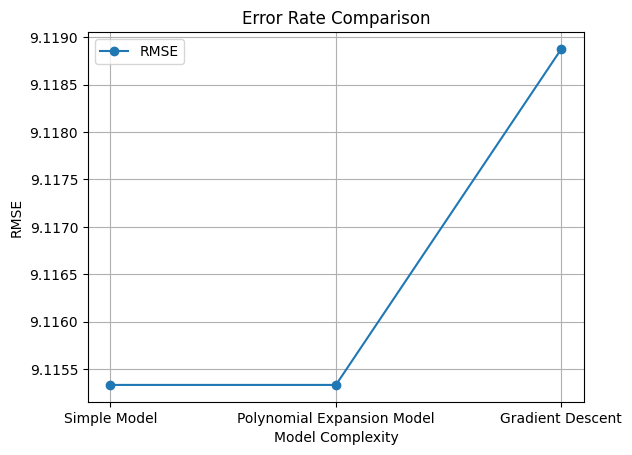

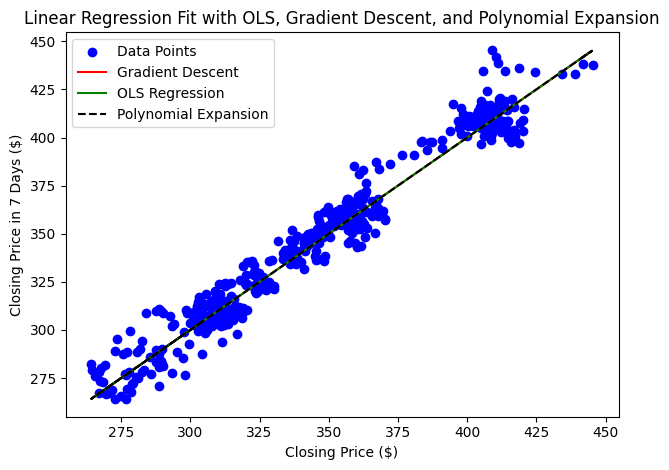

In [16]:
# OLS results
print(f"Linear Regression with OLS:\n  R2: {ols_r2}\n  RMSE: ${ols_rmse}")
print(f"  MAE: ${ols_mae}\n  Bias: {ols_bias}\n  Variance: {ols_variance}\n")

# Polynomial expansion
print(f"Regression with Polynomial Expansion:\n  R2: {poly_r2}\n  RMSE: ${poly_rmse}")
print(f"  MAE: ${poly_mae}\n  Bias: {poly_bias}\n  Variance: {poly_variance}\n")

# Gradient Descent
print(f"Linear Regression with Gradient Descent:\n  R2: {gd_r2}\n  RMSE: ${gd_rmse}")
print(f"  MAE: ${gd_mae}\n  Bias: {gd_bias}\n  Variance: {gd_variance}\n")

# Error Comparison Visualization
model_complexity = ['Simple Model', 'Polynomial Expansion Model', 'Gradient Descent']
mse_scores = [ols_rmse, poly_rmse, gd_rmse]

plt.plot(model_complexity, mse_scores, label='RMSE', marker='o')
plt.title('Error Rate Comparison')
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


# Plot the linear fit
x = np.array([0,10]).reshape(-1,1)
x_b = np.c_[np.ones((len(x), 1)), x]
plt.scatter(X_test, y_test, color='blue', label="Data Points")
plt.plot(gd_pred, gd_pred, color='red', label="Gradient Descent")
plt.plot(ols_pred, ols_pred, color='green', label="OLS Regression")
plt.plot(poly_pred,  poly_pred, "--", color='black', label="Polynomial Expansion")
plt.title(f"Linear Regression Fit with OLS, Gradient Descent, and Polynomial Expansion")
plt.xlabel("Closing Price ($)")
plt.ylabel("Closing Price in 7 Days ($)")
plt.legend()
plt.tight_layout()
plt.show()